# Preprocessing and Modelling

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 400

#Preprocessing libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Modelling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

#Metrics libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [2]:
#import data

df = pd.read_pickle("datasets/df.pkl")
df.head()

,subreddit,text
0,CPAP,MAD with a CPAP Has anyone tried this? Would it be advisable to use both?
1,CPAP,Anyone using a UPS or battery back up? Power in my area has been having a rough time lately and I have been wondering about getting one just in case. Anyone been using one or have and recommendations?
2,CPAP,"Mask with wide straps/better force distribution? Hi All, I need recommendations for full face masks with wide straps, especially the part that sits at the base of the skull, or a headgear system that distributes the force better and doesn't make it all converge on a single point.I'm currently using a large F20, which is a nice mask, but the straps give me headaches, even when very loose - the ..."
3,CPAP,"Mask Causing Permanent Face Indents I really am at my wits end everyone. I have my mask loosened as loose as possible, to the point it occasionally will leak, and still I have dents in my face. I am frustrated and depressed and am unsure what to do. I tried mask covers but those made it so there was 0 seal for my mask. I'm 23 but I feel as though my mask is aging me. On my cheeks besides my no..."
4,CPAP,"AirMini issue - mask broke on vacation, used universal adaptor TLDR: AirMini mask broke on a cruise, got a new mask when I returned to the US, universal adaptor worked ok, not sure if I like AirMini anymore. I’ve had an AirMini for around 5 years and take it frequently for business and vacation travel. It’s adequate and I’ve had no real complaints. This month I took it on a cruise out of Flori..."


We will first remove the youtube links as they don't add much meaning.

In [3]:
df.iloc[1600]['text']

'In the world of SLEEP, if there’s one specialty that gets it, it’s myofunctional therapy. Read this excellent article just published in CRANIO Journal:https://www.tandfonline.com/doi/full/10.1080/08869634.2022.2161768'

In [4]:
(df['text']
 .str
 .replace(pat='http\S*',repl='',regex=True)
 .iloc[1600]
)

'In the world of SLEEP, if there’s one specialty that gets it, it’s myofunctional therapy. Read this excellent article just published in CRANIO Journal:'

In [5]:
df['text']=(df['text']
 .str
 .replace(pat='http\S*',repl='',regex=True)
)

We will dummify the subreddit column. 0 represents sleep and 1 represent CPAP

In [6]:
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x=='CPAP' else 0)

In [7]:
#Check for unbalanced classes
df['subreddit'].value_counts()

1    986
0    932
Name: subreddit, dtype: int64

In [8]:
X = df['text']
y = df['subreddit']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

# Null Model

In [10]:
y.value_counts(normalize = True)

1    0.514077
0    0.485923
Name: subreddit, dtype: float64

The null model will have an almost 50 50 chance of getting the right one.

We will test each model using CountVectorizer and TF-IDF, using GridSearch to find the best parameters.

We will be using accuracy as our metric because we want to see how accuracutely the model can tell us who to advertise to.

Also, false negatives and false positives do not cause harm so we will not be using Specificity or Sensitivity.

In [11]:
#returns model and column names
def best_score_model(model:object, model_params:dict,vec_type:object):
    pipe = Pipeline([
        ('vec', vec_type()),
        ('model', model())
    ])
    
    pipe_params = {
                'vec__max_features': [500, 1000, 2000],
                'vec__stop_words': [text.ENGLISH_STOP_WORDS.union(['just','like','ve','got','don','cpap'])],
                'vec__ngram_range': [(1,1), (1,2)]
        }
    
    pipe_params.update(model_params
                      )
    if vec_type == CountVectorizer:
        vec_name = 'CountVectorizer'
    
    if vec_type == TfidfVectorizer:
        vec_name = 'TfidfVectorizer'        
    
    gs = GridSearchCV(pipe,
                     param_grid=pipe_params,
                     n_jobs=-1,
                     cv=10)
    
    gs.fit(X_train, y_train)
    
    print(f"For {vec_name}, the best parameters are")
    for params in gs.best_params_:
        if params!='vec__stop_words':
            print(f"{params}:{gs.best_params_[params]}")
    print(f"The train score is {gs.score(X_train, y_train)}.\nThe test score is {gs.score(X_test, y_test)}.")      
    
    return (gs.best_estimator_.steps[1][1], gs.best_estimator_.steps[0][1].get_feature_names_out())

# Naive Bayes Model

## Naive Bayes with CVec

In [12]:
nb_params = {'model__alpha':[.001,.01,.1,1]}

In [13]:
(nb_cvec_model,feature_names) = best_score_model(MultinomialNB, nb_params,CountVectorizer)

For CountVectorizer, the best parameters are
model__alpha:0.001
vec__max_features:1000
vec__ngram_range:(1, 2)
The train score is 0.9575799721835884.
The test score is 0.9375.


In [14]:
(pd.DataFrame(
    data={'log_prob_diff':nb_cvec_model.feature_log_prob_[1] - nb_cvec_model.feature_log_prob_[0]},
    index = feature_names)
 .assign(log_prob_exp=lambda x: np.exp(x))
 .sort_values(by='log_prob_diff')
 .head(25)
)

,log_prob_diff,log_prob_exp
melatonin,-11.240565,0.000013
pm,-10.684002,0.000023
cbd,-10.052749,0.000043
pills,-10.052749,0.000043
shift,-10.011929,0.000045
30am,-10.011929,0.000045
blanket,-9.924921,0.000049
alarms,-9.924921,0.000049
sleep time,-9.924921,0.000049
weed,-9.924921,0.000049


We notice that medications are a good indicator of people who generally have sleep problems. Melatonin, CBD, weed.

Time is also another indicator. Of the 25 significant tokens, 6 tokens are regarding time.

In [15]:
(pd.DataFrame(
    data={'log_prob_diff':nb_cvec_model.feature_log_prob_[1] - nb_cvec_model.feature_log_prob_[0]},
    index = feature_names)
 .assign(log_prob_exp=lambda x: np.exp(x))
 .sort_values(by='log_prob_diff',ascending = False)
 .head(25)
)

,log_prob_diff,log_prob_exp
resmed,12.347658,230419.757058
airsense,12.063088,173353.448377
hose,11.376139,87215.623952
masks,11.312424,81832.009926
airsense 11,11.258357,77525.118705
airsense 10,11.230187,75371.673094
humidifier,11.186385,72141.504678
tube,11.156080,69988.059068
oscar,11.140576,68911.336262
settings,11.076038,64604.445041


For  CPAP users, the brands 'resmed' and 'phillips' will classify them strongly.

The CPAP models like f20, airsense, p10, and airfit also are good indicators.

CPAP accessories are also good indicators, like hose, masks, tank, and tube.

The mention of Oscar will also indicate strongly as it is a computer programme that CPAP users use.

DME stands for Durable Medical Equipment

From our interpretable model, we can see that we should not lemmatize or stem the words because for significant tokens,

- There is no need, the tokens (other than masks) do not collect when lemmatized/stemmed
- It will reduce the interpretability (for example, settings will become setting, which can obviously be confusion)

## Naive Bayes with TF-IDF

In [16]:
(nb_tfid_model,feature_names) = best_score_model(MultinomialNB, nb_params,TfidfVectorizer)

For TfidfVectorizer, the best parameters are
model__alpha:0.1
vec__max_features:2000
vec__ngram_range:(1, 2)
The train score is 0.972183588317107.
The test score is 0.9395833333333333.


In [17]:
(pd.DataFrame(
    data={'log_prob_diff':nb_tfid_model.feature_log_prob_[1] - nb_tfid_model.feature_log_prob_[0]},
    index = feature_names)
 .assign(log_prob_exp=lambda x: np.exp(x))
 .sort_values(by='log_prob_diff')
 .head(25)
)

,log_prob_diff,log_prob_exp
melatonin,-4.436944,0.011832
relaxing music,-4.205386,0.014915
music sleep,-4.175477,0.015368
pm,-3.958750,0.019087
dreams,-3.731321,0.023961
sleep schedule,-3.712032,0.024428
school,-3.670876,0.025454
insomnia,-3.668833,0.025506
aid,-3.630471,0.026504
cbd,-3.609740,0.027059


In [18]:
(pd.DataFrame(
    data={'log_prob_diff':nb_tfid_model.feature_log_prob_[1] - nb_tfid_model.feature_log_prob_[0]},
    index = feature_names)
 .assign(log_prob_exp=lambda x: np.exp(x))
 .sort_values(by='log_prob_diff',ascending = False)
 .head(25)
)

,log_prob_diff,log_prob_exp
resmed,5.318753,204.129170
airsense,5.173644,176.557001
oscar,4.818509,123.780428
masks,4.663241,105.978988
airsense 10,4.593756,98.865104
airsense 11,4.513166,91.210158
tube,4.509461,90.872821
hose,4.506517,90.605688
humidifier,4.445514,85.243683
philips,4.358889,78.170252


# Logistic Regression

In [19]:
lr_params = {'model__penalty':['l2'],
            'model__C':[.1,1,100],
            'model__solver':['lbfgs','liblinear'],
            'model__max_iter':[100,500,1000]}

## Logistic Regression CVec

In [20]:
(lr_cvec_model,feature_names) = best_score_model(LogisticRegression, lr_params,CountVectorizer)

For CountVectorizer, the best parameters are
model__C:1
model__max_iter:100
model__penalty:l2
model__solver:lbfgs
vec__max_features:2000
vec__ngram_range:(1, 2)
The train score is 0.9937413073713491.
The test score is 0.9291666666666667.


In [21]:
(pd.DataFrame(
    data={'log_prob':lr_cvec_model.coef_[0]},
    index=feature_names)
.assign(log_prob_exp=lambda x: np.exp(x))
.sort_values(by='log_prob', ascending=False)
.head(15)
)

,log_prob,log_prob_exp
mask,1.914638,6.784479
machine,1.657396,5.245632
using,1.451440,4.269259
apnea,1.362070,3.904267
sleep study,1.197884,3.313098
oscar,1.110914,3.037133
sleep apnea,1.098669,3.000171
air,1.050984,2.860465
resmed,1.019048,2.770556
pressure,0.947760,2.579923


In [22]:
(pd.DataFrame(
    data={'log_prob':lr_cvec_model.coef_[0]},
    index=feature_names)
.assign(log_prob_exp=lambda x: np.exp(x))
.sort_values(by='log_prob', ascending=True)
.head(15)
)

,log_prob,log_prob_exp
dreams,-1.432442,0.238725
sleep,-1.333682,0.263505
bed,-1.229535,0.292429
relaxing,-1.179645,0.307388
music,-0.933816,0.393051
melatonin,-0.847833,0.428342
sleeping,-0.846867,0.428756
sound,-0.777614,0.459501
wake,-0.773984,0.461172
hot,-0.733343,0.480301


## Logistic Regression TF-IDF

In [23]:
(lr_tfid_model,feature_names) = best_score_model(LogisticRegression, lr_params,TfidfVectorizer)

For TfidfVectorizer, the best parameters are
model__C:100
model__max_iter:100
model__penalty:l2
model__solver:lbfgs
vec__max_features:2000
vec__ngram_range:(1, 2)
The train score is 0.9986091794158554.
The test score is 0.9395833333333333.


In [24]:
(pd.DataFrame(
    data={'log_prob':lr_tfid_model.coef_[0]},
    index=feature_names)
.assign(log_prob_exp=lambda x: np.exp(x))
.sort_values(by='log_prob', ascending=False)
.head(15)
)

,log_prob,log_prob_exp
mask,13.962970,1.158886e+06
machine,11.347187,8.472677e+04
using,10.043886,2.301464e+04
apnea,7.603029,2.004257e+03
air,7.181058,1.314298e+03
sleep apnea,7.177085,1.309086e+03
sleep study,7.006656,1.103957e+03
pressure,6.950850,1.044037e+03
resmed,6.939809,1.032573e+03
starting,6.401268,6.026084e+02


In [25]:
(pd.DataFrame(
    data={'log_prob':lr_tfid_model.coef_[0]},
    index=feature_names)
.assign(log_prob_exp=lambda x: np.exp(x))
.sort_values(by='log_prob', ascending=True)
.head(15)
)

,log_prob,log_prob_exp
sleep,-15.673336,1.560115e-07
bed,-8.700644,1.664785e-04
dreams,-7.201495,7.454708e-04
insomnia,-6.581006,1.386454e-03
wake,-6.104370,2.233088e-03
combination,-5.759728,3.151970e-03
melatonin,-5.603683,3.684269e-03
sleeping,-5.413079,4.457891e-03
relaxing,-5.100805,6.091840e-03
ways,-5.083681,6.197053e-03


# k nearest neighbours model

In [26]:
def best_score_model_with_ss(model:object, model_params:dict,vec_type:object):
    pipe = Pipeline([
        ('vec', vec_type()),
        ('ss',StandardScaler(with_mean=False)),
        ('model', model())
    ])
    
    pipe_params = {
                'vec__max_features': [500, 1000, 2000],
                'vec__stop_words': [text.ENGLISH_STOP_WORDS.union(['just','like','ve','got','don','cpap'])],
                'vec__ngram_range': [(1,1), (1,2)]
        }
    
    pipe_params.update(model_params
                      )
    if vec_type == CountVectorizer:
        vec_name = 'CountVectorizer'
    
    if vec_type == TfidfVectorizer:
        vec_name = 'TfidfVectorizer'        
    
    gs = GridSearchCV(pipe,
                     param_grid=pipe_params,
                     n_jobs=-1,
                     cv=10)
    
    gs.fit(X_train, y_train)
    
    print(f"For {vec_name}, the best parameters are")
    for params in gs.best_params_:
        if params!='vec__stop_words':
            print(f"{params}:{gs.best_params_[params]}")
    print(f"The train score is {gs.score(X_train, y_train)}.\nThe test score is {gs.score(X_test, y_test)}.")      
    
    return (gs.best_estimator_.steps[2][1], gs.best_estimator_.steps[1][1].get_feature_names_out())

In [27]:
knn__params = {
    'model__p': [1,2],
    'model__weights': ['uniform','distance'],
    'model__n_neighbors': [3,5,10],
}

## KNN CVec

In [28]:
(knn_cvec_model, feature_names)=best_score_model_with_ss(KNeighborsClassifier, knn__params,CountVectorizer)

For CountVectorizer, the best parameters are
model__n_neighbors:10
model__p:2
model__weights:uniform
vec__max_features:500
vec__ngram_range:(1, 2)
The train score is 0.8616133518776078.
The test score is 0.7958333333333333.


C:\Users\hammi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hammi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

## KNN TFID

In [29]:
(knn_tfid_model, feature_names)=best_score_model_with_ss(KNeighborsClassifier, knn__params,TfidfVectorizer)

For TfidfVectorizer, the best parameters are
model__n_neighbors:10
model__p:1
model__weights:distance
vec__max_features:2000
vec__ngram_range:(1, 1)
The train score is 0.9986091794158554.
The test score is 0.8083333333333333.


The best KNN model given the best hyperparameters still pales in comparison to Naive Bayes

# Decision Trees

In [30]:
dt_params ={
    "model__max_depth" : [3,4,5,6]
}

In [31]:
(dt_cvec_model,feature_names) = best_score_model(DecisionTreeClassifier, dt_params,CountVectorizer)

For CountVectorizer, the best parameters are
model__max_depth:6
vec__max_features:1000
vec__ngram_range:(1, 1)
The train score is 0.913769123783032.
The test score is 0.875.


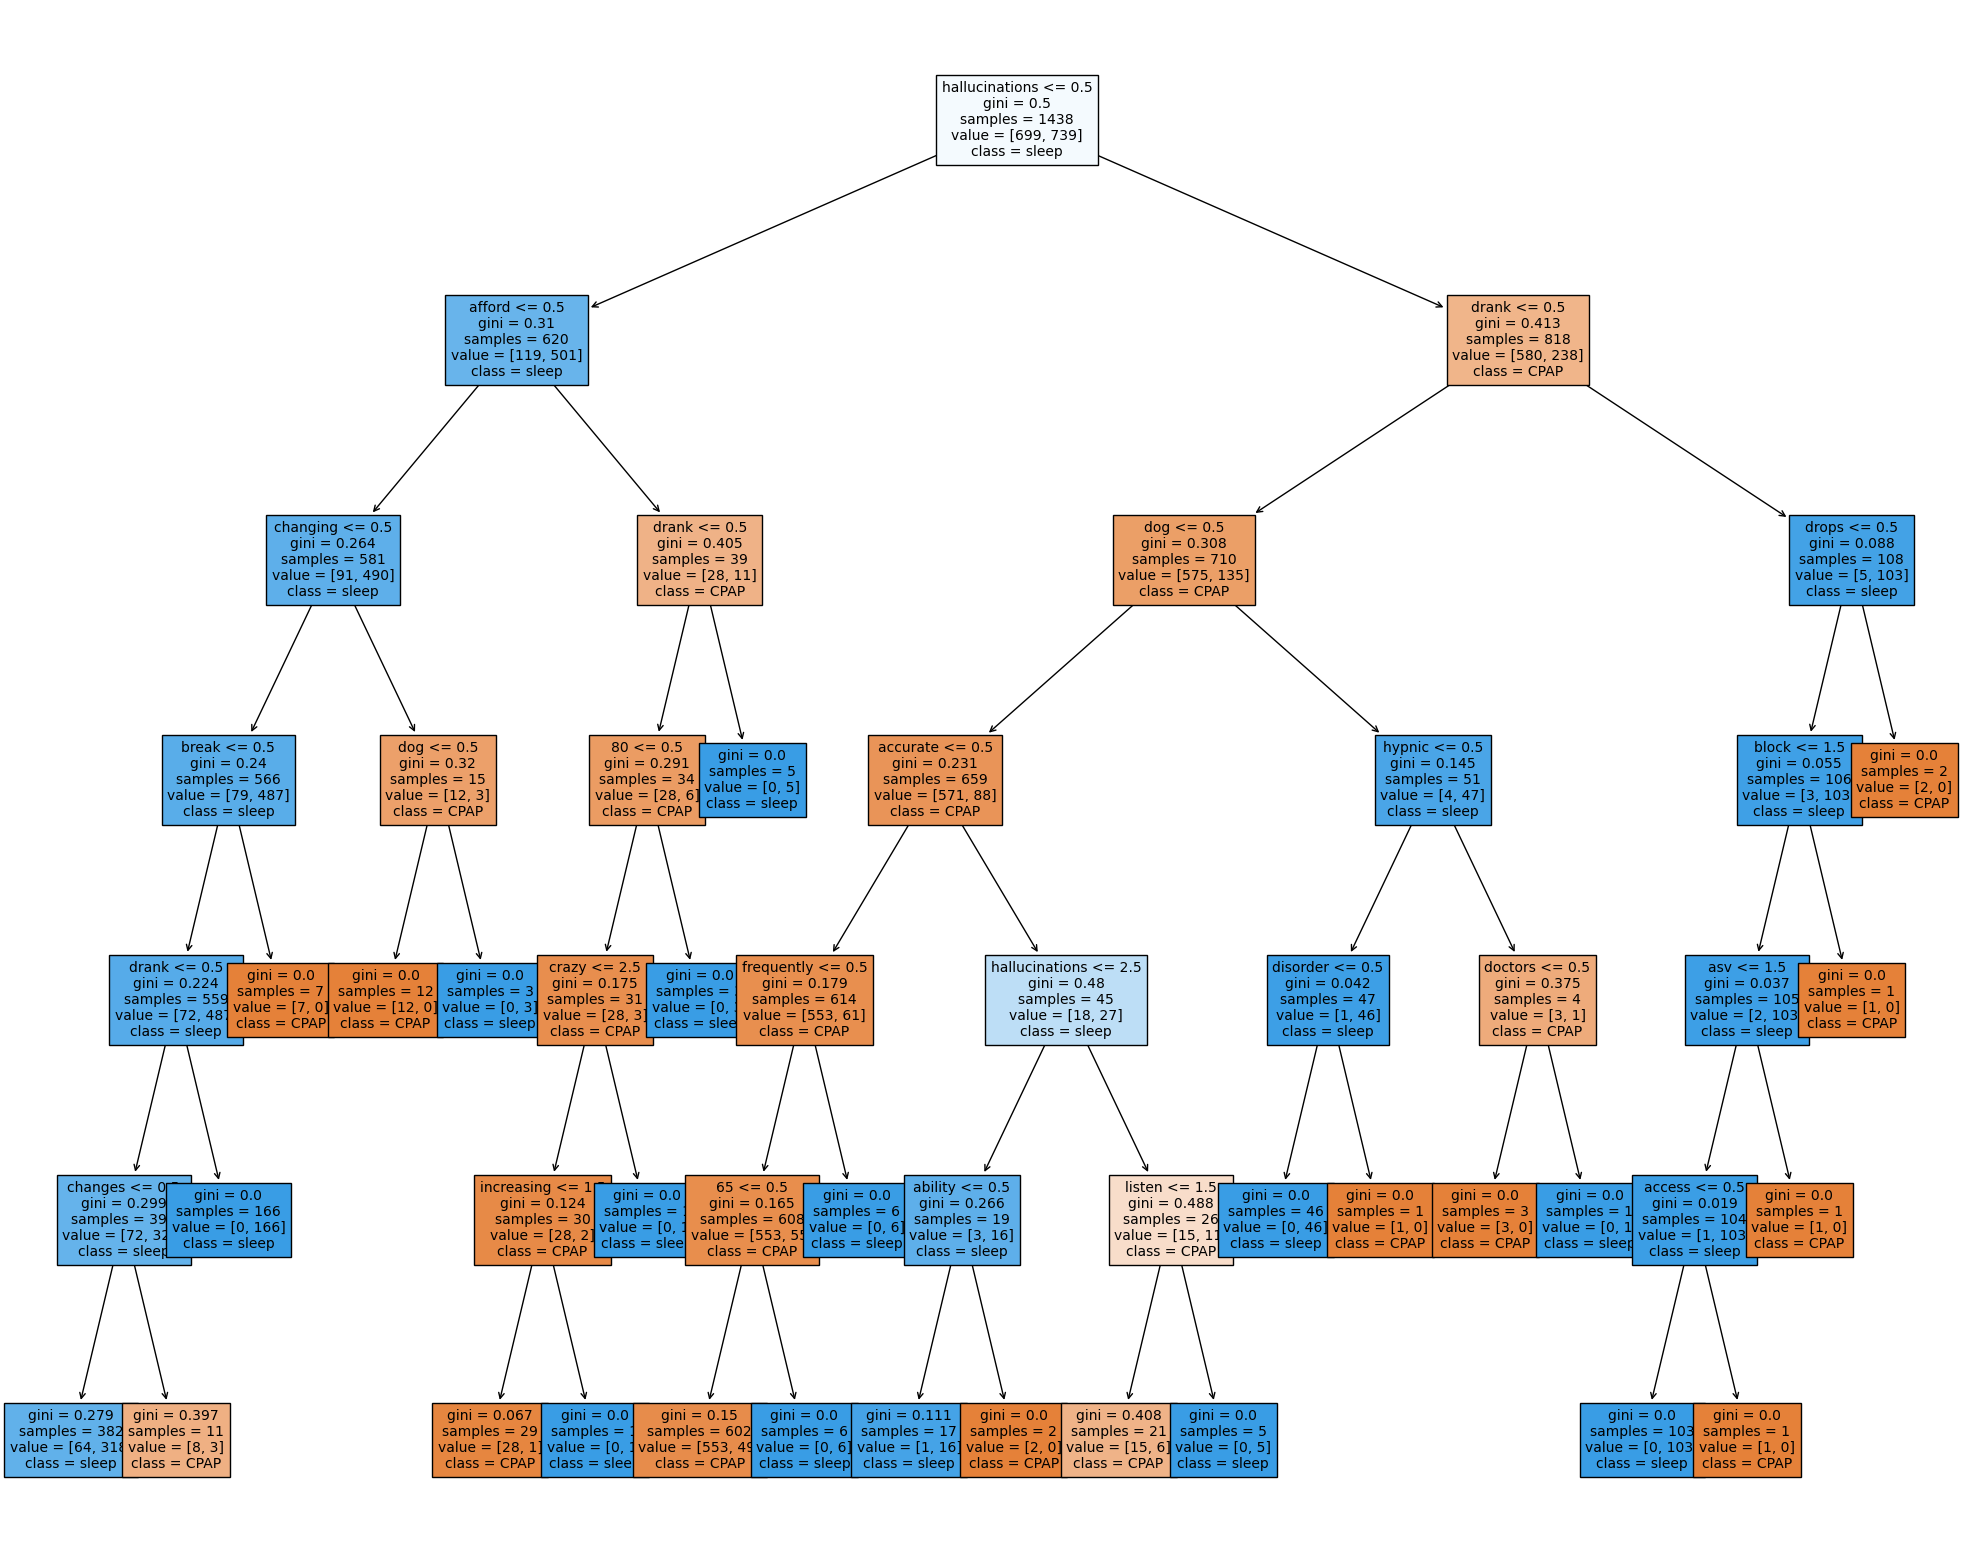

In [36]:
plt.figure(figsize=(25,20))

plot_tree(dt_cvec_model,
          feature_names = feature_names,
          class_names = ['CPAP', 'sleep'],
          filled = True,
         fontsize=10);

In [33]:
(dt_tfid_model,feature_names) = best_score_model(DecisionTreeClassifier, dt_params,TfidfVectorizer)

For TfidfVectorizer, the best parameters are
model__max_depth:6
vec__max_features:2000
vec__ngram_range:(1, 1)
The train score is 0.9123783031988874.
The test score is 0.8708333333333333.


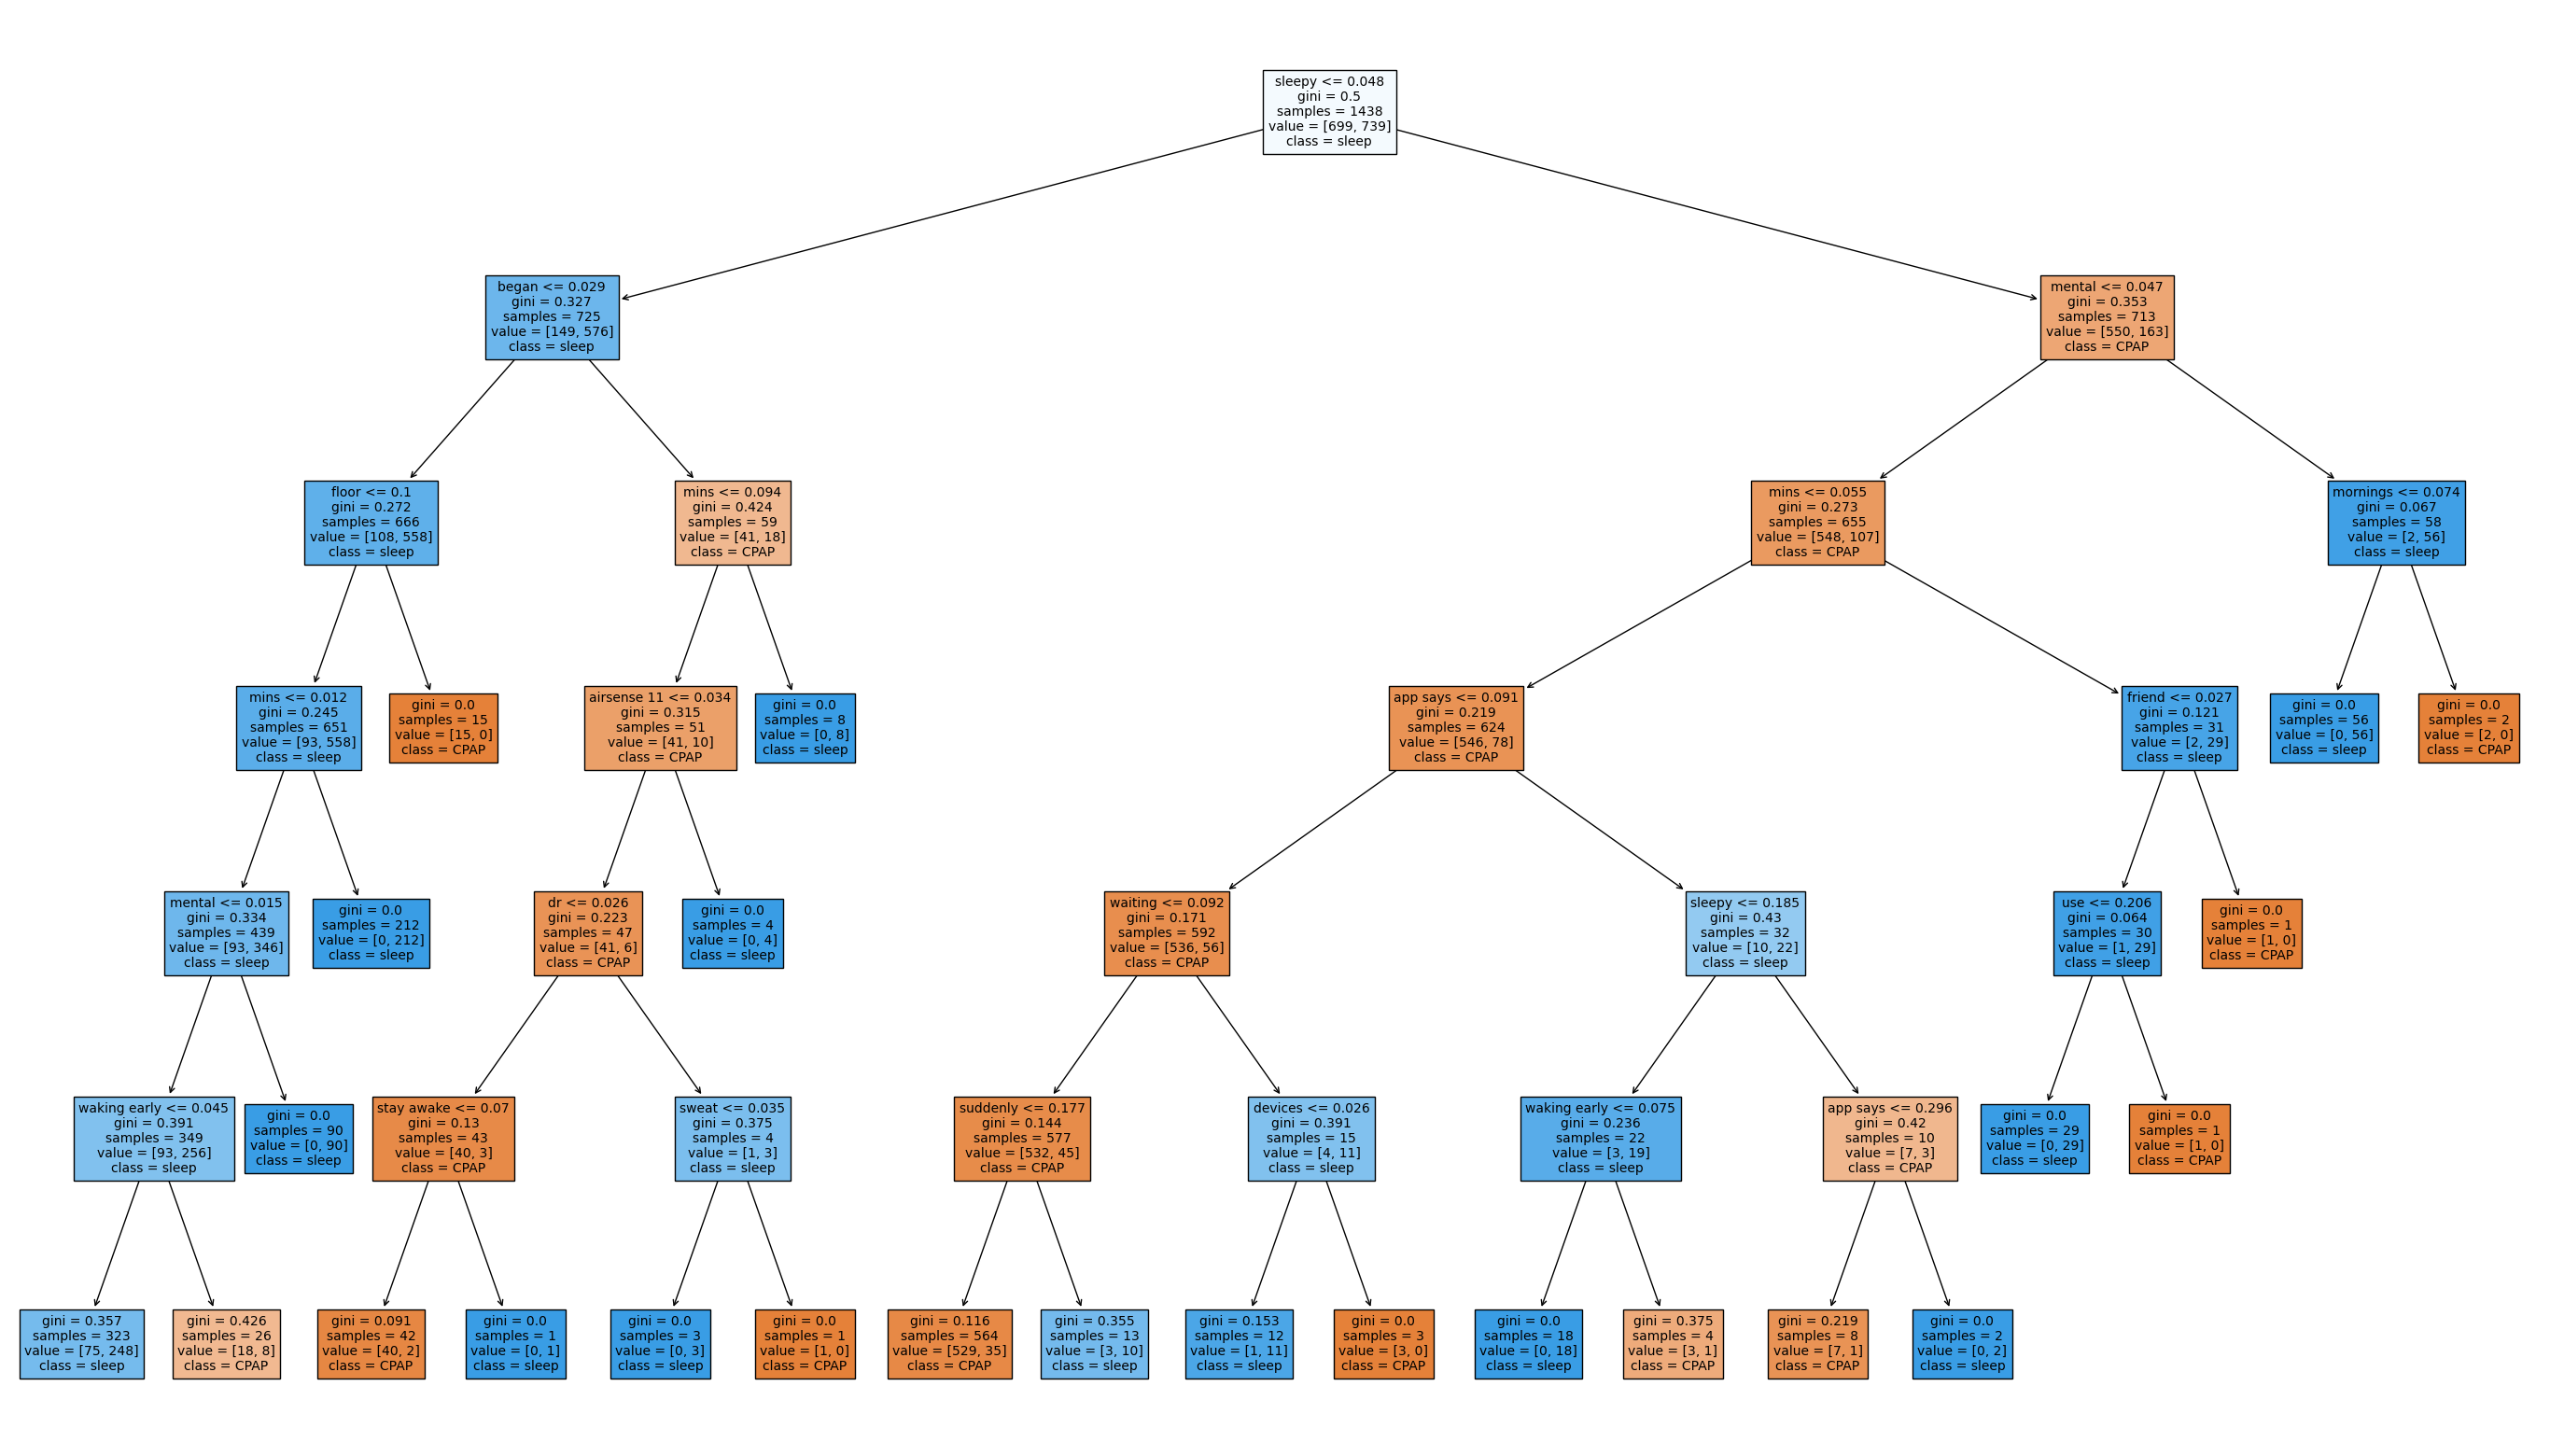

In [46]:
plt.figure(figsize=(35,20))

plot_tree(dt_tfid_model,
          feature_names = feature_names,
          class_names = ['CPAP', 'sleep'],
          filled = True,
         fontsize=10);

# Adaboost Classifier

In [42]:
ada_params = {
    'model__base_estimator':[DecisionTreeClassifier()],
    'model__n_estimators': [50,100],
    'model__base_estimator__max_depth': [1,2],
    'model__learning_rate': [.9, 1.],
    'model__base_estimator__max_depth':[3,4,5]
}

In [43]:
(ada_cvec_model,feature_names) = best_score_model(AdaBoostClassifier, ada_params,CountVectorizer)

For CountVectorizer, the best parameters are
model__base_estimator:DecisionTreeClassifier(max_depth=4)
model__base_estimator__max_depth:4
model__learning_rate:0.9
model__n_estimators:100
vec__max_features:1000
vec__ngram_range:(1, 2)
The train score is 0.997913769123783.
The test score is 0.9125.


In [44]:
(ada_tdif_model,feature_names) = best_score_model(AdaBoostClassifier, ada_params,TfidfVectorizer)

For TfidfVectorizer, the best parameters are
model__base_estimator:DecisionTreeClassifier(max_depth=5)
model__base_estimator__max_depth:5
model__learning_rate:0.9
model__n_estimators:100
vec__max_features:2000
vec__ngram_range:(1, 2)
The train score is 0.9986091794158554.
The test score is 0.8895833333333333.
